<a href="https://colab.research.google.com/github/man-r/ICS-504/blob/main/ICS504_project_fasterrcnn_resnet50_fpn_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network for Wheelchair Accessible Sidewalks Deduction


## Installs and Imports

Install and import PyTorch along with a few helper libraries

In [1]:
# Install dependencies and 
!pip install albumentations==0.4.6
!pip install pycocotools --quiet

# Clone TorchVision repo and copy helper files
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout
%cd ..
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65156 sha256=02a836393b37b25b0a16ccdb06d65f6b89ebbc31a894bb7893f94c6d9fdfb6d3
  Stored in directory: /root/.cache/pip/wheels/f9/d7/0c/6ed42fd872f7d1af78b25045f8b16be330f2c70ae72c83e37d
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
Cloning into 'vision'...
remote: Enumerating objects: 332261, done.
remote: Counting objects: 100% (67171/67171), done.
remote: Compressing objects: 100% (1005/1005), done.
remote: Total 332261 (delta 66699), reused 66510 (delta 66147), pack-reused 265090
Receiving objects: 100% (332261/

Lets import the libraries

In [2]:
# basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd

# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# helper libraries
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## The Dataset 

For this project we utilize the dataset collected by Project Sidewalk. Project Sidewalk dataset is a collection of geospatial data about sidewalk accessibility in Chicago. It was created by the Makeability Lab at the University of Washington, and it is available for free to anyone who wants to use it. The dataset includes information about the condition of sidewalks, the presence of accessibility features.
It includes information about the condition of sidewalks, such as whether they are cracked, uneven, or blocked by debris.
It identifies the presence of accessibility features, such as curb ramps, accessible parking spaces, and accessible bus stops.
For this project we focused on four sidewalk assessments (labels):  curb ramps, missing curb ramps, obstructions, and surface problems.





The data will be in be in form of list with the following parameters:
1.	Pano_id: GSV panoramic images identification number
2.	SV_x: x coordinate of the object location in the image
3.	SV_y: y 	coordinate of the object location in the image
4.	Photographer Heading: important parameter needed to extract the cropped images. 
5.	Heading: important parameter needed to extract the cropped images
6.	Label_ID: a number from 1 to 4 to identify the object category.

## Creating the panoramic images
For licensing reason, the panoramic images are not available in the in the Project Sidewalk instead the GSV pano id is provided and using that pano id 43 images needed to be downloaded and then stitched together in order to make a single panoramic image

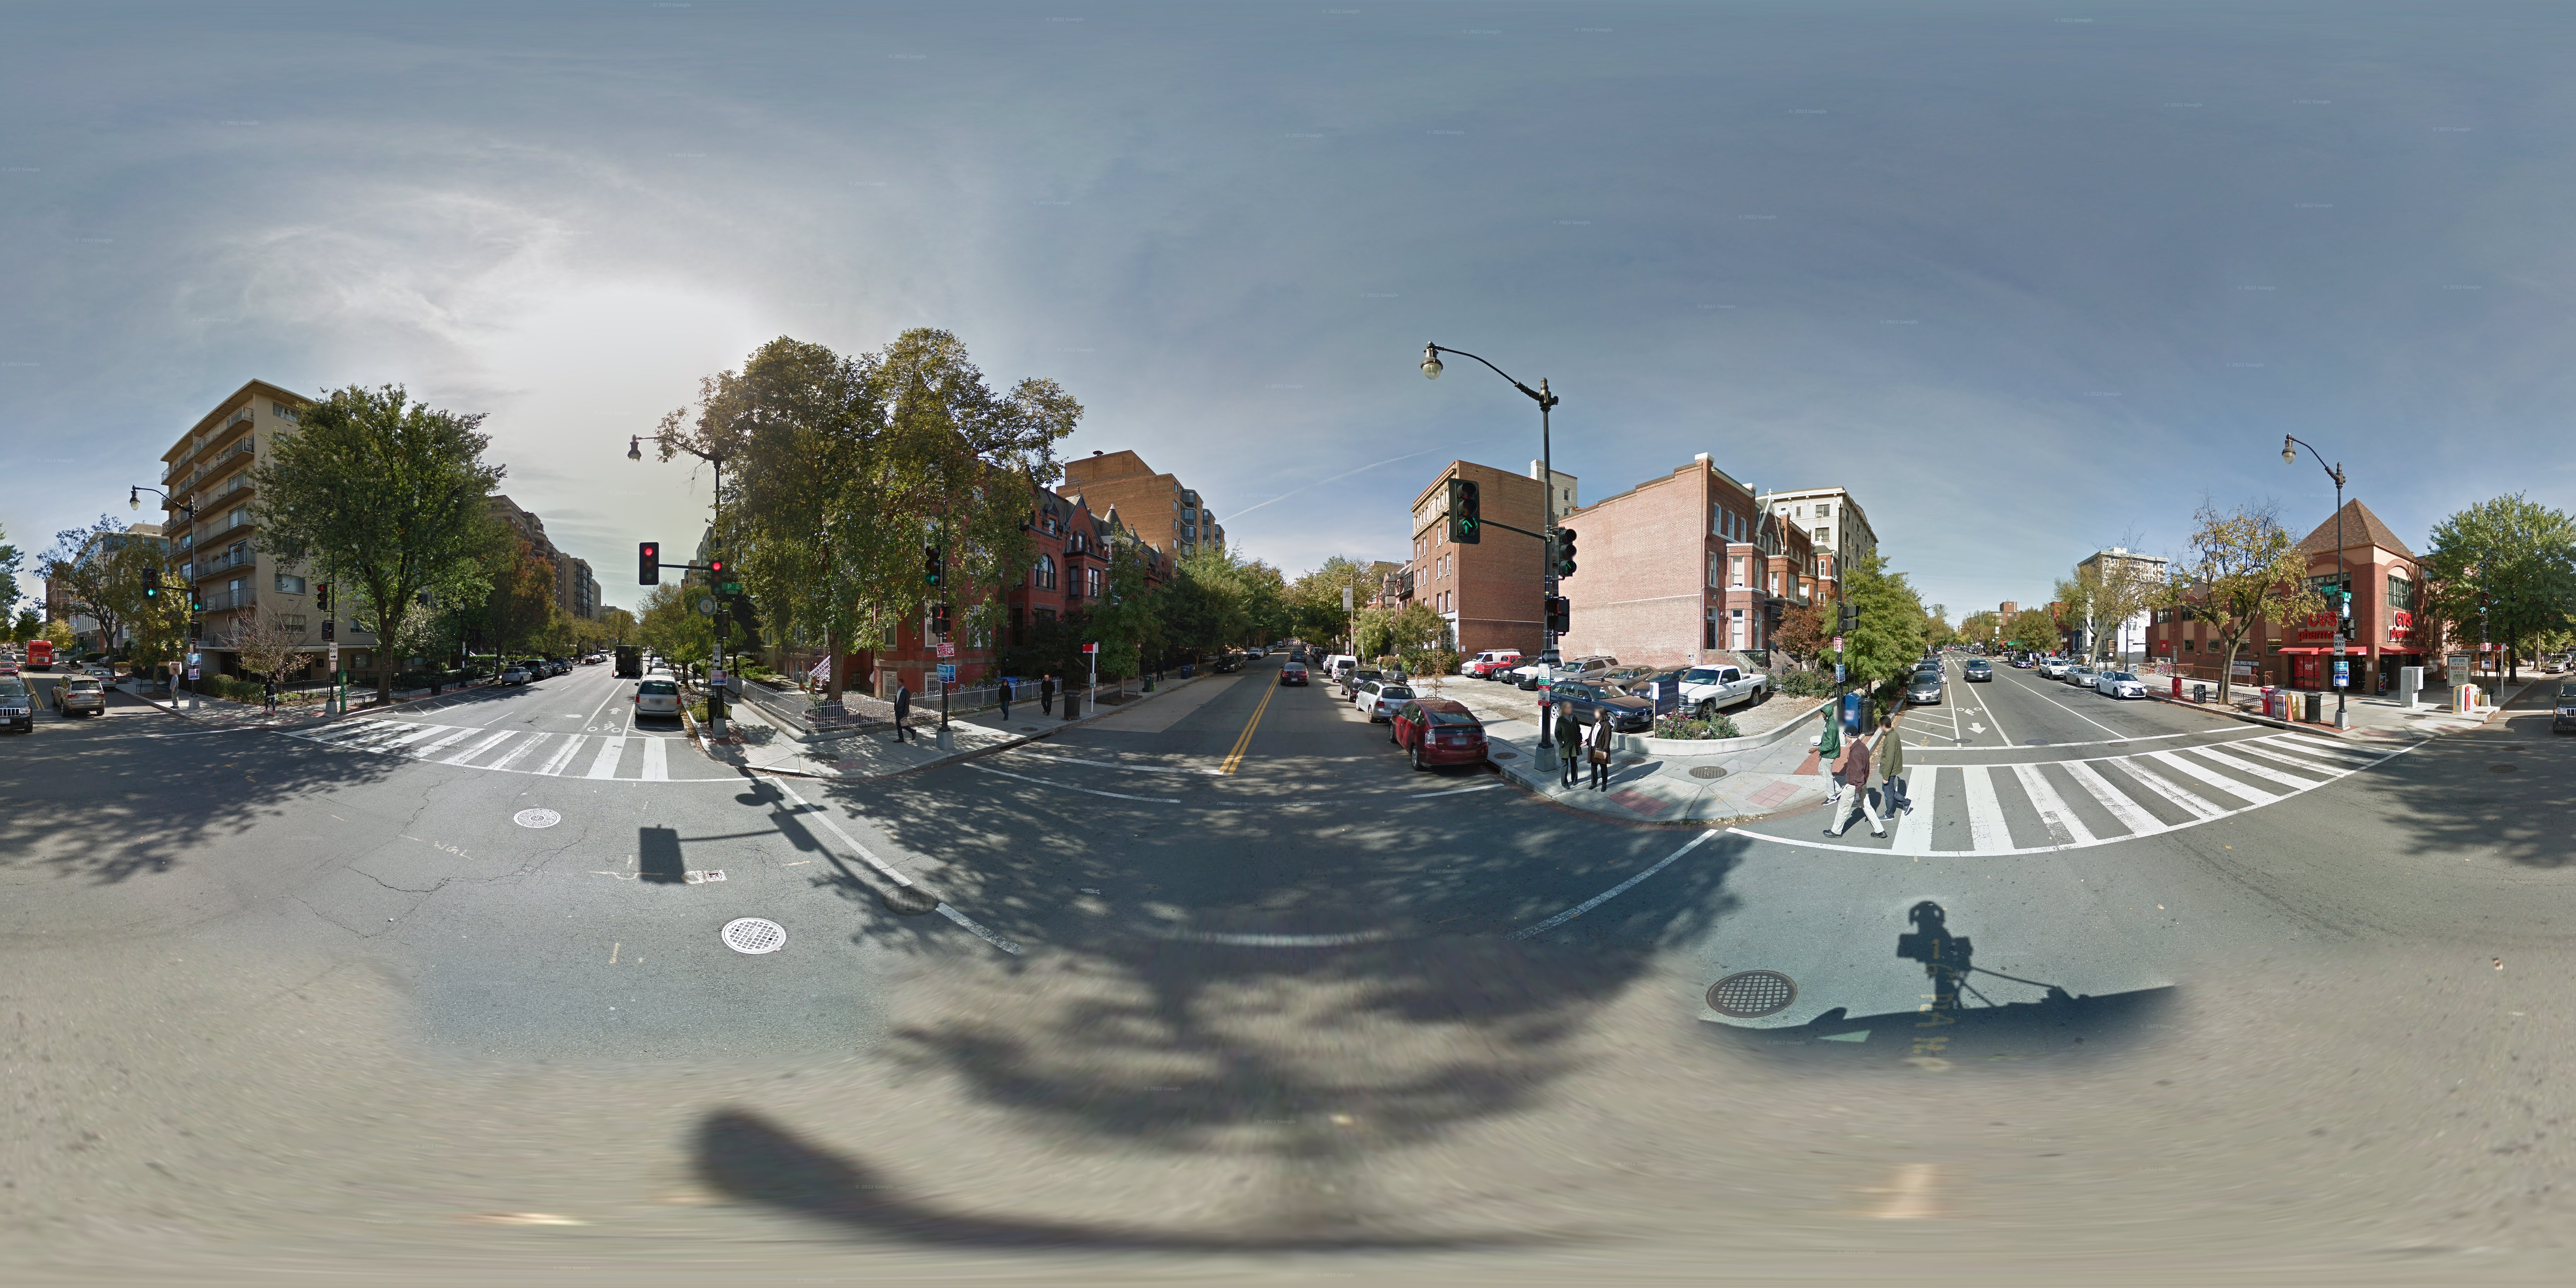

https://maps.googleapis.com/maps/api/streetview/v1/pano?panoid=_esTApCuEf3hJXPt_KMc9Q

## Creating the annotation files for each image
Using the downloaded panoramic images and the object location information in project sidewalk dataset the an annotation text file was created for each panoramic image containing the object location and the object label

### example
1 0.524258764877972  0.5118060600978243 0.524258764877972 0.5118060600978243

1 0.5676150799451982 0.4978576325399692 0.5676150799451982 0.4978576325399692

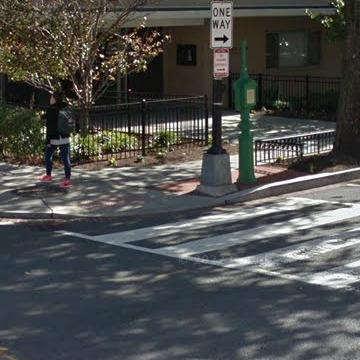
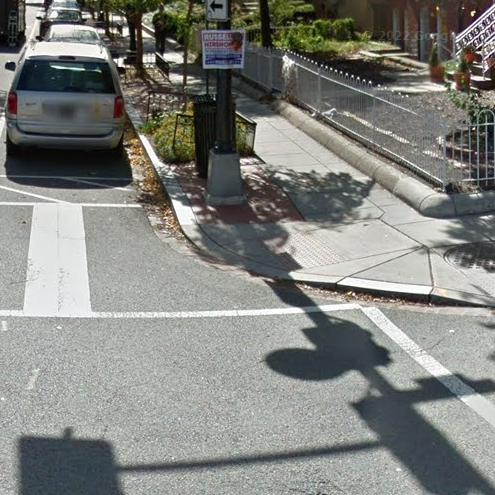



https://github.com/ProjectSidewalk/sidewalk-panorama-tools

In [3]:
# defining the files directory
files_dir = '/content/gdrive/MyDrive/ICS504/github/ICS-504/download_images/sample/'
bbox_dir = '/content/gdrive/MyDrive/ICS504/github/ICS-504/bbox/'

# we create a Dataset class which has a __getitem__ function and a __len__ function
class SidewalkImagesDataset(torch.utils.data.Dataset):

  def __init__(self, files_dir, bbox_dir, width, height, transforms=None):
    self.transforms = transforms
    self.files_dir = files_dir
    self.bbox_dir = bbox_dir
    self.height = height
    self.width = width
    
    # sorting the images for consistency
    # To get images, the extension of the filename is checked to be jpg
    self.imgs = [image for image in sorted(os.listdir(files_dir)) if image[-4:]=='.jpg']
    
    # classes: 0 index is reserved for background
    self.classes = [_, 'class1', 'class2', 'class3', 'class4', 'class5']

  def __getitem__(self, idx):
    img_name = self.imgs[idx]
    image_path = os.path.join(self.files_dir, img_name)

    # reading the images and converting them to correct size and color    
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
    # diving by 255
    img_res /= 255.0
    
    # annotation file
    annot_filename = img_name[:-4] + '.txt'
    annot_file_path = os.path.join(self.bbox_dir, annot_filename)
    
    boxes = []
    labels = []
    
    # cv2 image gives size as height x width
    wt = img.shape[1]
    ht = img.shape[0]

    # box coordinates for xml files are extracted and corrected for image size given
    with open(annot_file_path) as f:
      for line in f:
        
        parsed = [float(x) for x in line.split(' ')]
        
        l = int(parsed[0])
        if(l==8):
          label = 4
        labels.append(l)
        xmin = parsed[1]
        ymin = parsed[2]
        xmax = parsed[3]+0.1
        ymax = parsed[4]+0.1
        
        xmin_corr = int(xmin*self.width)
        xmax_corr = int(xmax*self.width)
        ymin_corr = int(ymin*self.height)
        ymax_corr = int(ymax*self.height)
        
        boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
    
    # convert boxes into a torch.Tensor
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    
    # getting the areas of the boxes
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

    # suppose all instances are not crowd
    iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
    
    labels = torch.as_tensor(labels, dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["area"] = area
    target["iscrowd"] = iscrowd
    image_id = torch.tensor([idx])
    target["image_id"] = image_id

    if self.transforms:
      sample = self.transforms(image = img_res,
                                bboxes = target['boxes'],
                                labels = labels)
      img_res = sample['image']
      target['boxes'] = torch.Tensor(sample['bboxes'])
        
    return img_res, target

  def __len__(self):
    return len(self.imgs)


# check dataset
full_dataset = SidewalkImagesDataset(files_dir, bbox_dir, 480, 480)

print('Length of dataset:', len(full_dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = full_dataset[7]
print('Image shape:', img.shape)
print('Label example:', target)

Length of dataset: 1544 

Image shape: (480, 480, 3)
Label example: {'boxes': tensor([[302., 220., 350., 268.],
        [347., 245., 395., 293.],
        [377., 241., 425., 289.],
        [ 52., 245., 100., 293.],
        [289., 210., 337., 258.],
        [ 54., 245., 102., 293.],
        [ 53., 243., 101., 291.]]), 'labels': tensor([1, 2, 4, 1, 1, 1, 1]), 'area': tensor([2304., 2304., 2304., 2304., 2304., 2304., 2304.]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0]), 'image_id': tensor([7])}


# Visualization


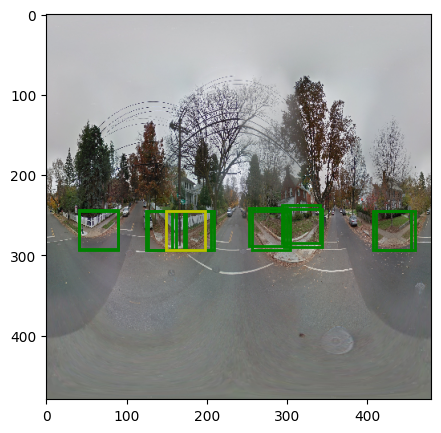

In [4]:
from PIL import Image, ImageDraw

# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target):
  # plot the image and bboxes
  # Bounding boxes are defined as follows: x-min y-min width height
  fig, a = plt.subplots(1,1)
  fig.set_size_inches(5,5)
  a.imshow(img)
  for i in range(len(target['boxes'])):
    x, y, width, height  = target['boxes'][i][0], target['boxes'][i][1], target['boxes'][i][2]-target['boxes'][i][0], target['boxes'][i][3]-target['boxes'][i][1]
    label = target['labels'][i]
    if(label == 1):
      rect = patches.Rectangle(
        (x, y),
        width, height,
        linewidth = 2,
        edgecolor = 'g',
        facecolor = 'none')
    elif(label == 2):
      rect = patches.Rectangle(
        (x, y),
        width, height,
        linewidth = 2,
        edgecolor = 'b',
        facecolor = 'none'
      )
    elif(label == 3):
      rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 2,
      edgecolor = 'y',
      facecolor = 'none'
    )
    else:
      rect = patches.Rectangle(
      (x, y),
      width, height,
      linewidth = 2,
      edgecolor = 'r',
      facecolor = 'none'
    )
    # Draw the bounding box on top of the image
    a.add_patch(rect)

    # im = Image.fromarray(img.astype('uint8'), 'RGB')
    # cropped_square = im.crop((x.item(), y.item(), x.item()+50, y.item()+50 ))
    # im.save('img.jpg')
  plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = full_dataset[6]
plot_img_bbox(img, target)


# Dataloaders

Make a loader for feeding our data into the neural network

Now lets prepare the datasets and dataloaders for training and testing.

In [5]:
# Send train=True for training transforms and False for val/test transforms
def get_transform(train):
  if train:
    return A.Compose(
      [
        # ToTensorV2 converts image to pytorch tensor without div by 255
        ToTensorV2(p=1.0) 
      ],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )
  else:
    return A.Compose(
      [ToTensorV2(p=1.0)],
      bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']}
    )

In [7]:
# use our dataset and defined transformations
full_dataset = SidewalkImagesDataset(files_dir, bbox_dir, 480, 480, transforms=get_transform(train=True))


# split the dataset in train and test set
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])


# define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=5,
  shuffle=True,
  num_workers=4,
  collate_fn=utils.collate_fn,
)

data_loader_test = torch.utils.data.DataLoader(
  test_dataset,
  batch_size=5,
  shuffle=False,
  num_workers=4,
  collate_fn=utils.collate_fn,
)

# Pre-trained Model

We use a deep learning approach called a Faster Region-based Convolutional Neural Network (Faster R-CNN). It was introduced in 2015 by Ross Girshick, Shaoqing Ren, Kaiming He, and Jian Sun. Faster R-CNN is an improvement over the R-CNN model, which was also developed by Girshick. It has been used to achieve state-of-the-art results on a variety of object detection benchmarks. Faster R-CNN is a popular choice for object detection in a variety of applications, including autonomous driving, facial recognition, and image search

In [8]:
def get_object_detection_model(num_classes, version='v1'):
  # load a model pre-trained pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  if(version == 'v2'):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')
  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
  return model

# Training

Let's prepare the model for training

In [9]:
# train on gpu if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 5 # one class (class 0) is dedicated to the "background"

# get the model using our helper function
model = get_object_detection_model(num_classes,version='v2')

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(
  optimizer,
  step_size=3,
  gamma=0.1
)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 260MB/s]
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:02<00:00, 67.1MB/s]


In [10]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [11]:
model_dir = '/content/gdrive/MyDrive/ICS504/github/ICS-504/'

# training for 5 epochs
num_epochs = 5
train_loss = []
train_loss_classifier = []
train_loss_box_reg = []
eval_result = []
train_loss_objectness = []
train_loss_rpn_box_reg = []
for epoch in range(num_epochs):
    # training for one epoch
    train_result = train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=100)
    train_loss.append(train_result.meters['loss'].avg)
    train_loss_classifier.append(train_result.meters['loss_classifier'].avg)
    train_loss_box_reg.append(train_result.meters['loss_box_reg'].avg)
    train_loss_objectness.append(train_result.meters['loss_objectness'].avg)
    train_loss_rpn_box_reg.append(train_result.meters['loss_rpn_box_reg'].avg)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

    torch.save(model.state_dict(), model_dir+'model_v2.pth')

Epoch: [0]  [  0/247]  eta: 1:28:05  lr: 0.000025  loss: 2.3642 (2.3642)  loss_classifier: 1.9961 (1.9961)  loss_box_reg: 0.0500 (0.0500)  loss_objectness: 0.2951 (0.2951)  loss_rpn_box_reg: 0.0231 (0.0231)  time: 21.3981  data: 12.2189  max mem: 6547
Epoch: [0]  [100/247]  eta: 0:07:32  lr: 0.002056  loss: 0.5517 (0.8849)  loss_classifier: 0.2450 (0.5026)  loss_box_reg: 0.2804 (0.2300)  loss_objectness: 0.0321 (0.1375)  loss_rpn_box_reg: 0.0068 (0.0148)  time: 2.9265  data: 1.4537  max mem: 6748
Epoch: [0]  [200/247]  eta: 0:02:19  lr: 0.004086  loss: 0.4263 (0.6868)  loss_classifier: 0.2108 (0.3665)  loss_box_reg: 0.2006 (0.2295)  loss_objectness: 0.0172 (0.0813)  loss_rpn_box_reg: 0.0031 (0.0095)  time: 2.6729  data: 1.2031  max mem: 6748
Epoch: [0]  [246/247]  eta: 0:00:02  lr: 0.005000  loss: 0.3602 (0.6350)  loss_classifier: 0.1767 (0.3356)  loss_box_reg: 0.1694 (0.2216)  loss_objectness: 0.0159 (0.0694)  loss_rpn_box_reg: 0.0025 (0.0083)  time: 2.9603  data: 1.4889  max mem: 674

# Visualising the loss

In [ ]:
IoU_recall = [0.053,0.067,0.074,0.070, 0.067]
plt.title('IoU recall')
plt.plot(IoU_recall)
plt.xlabel('epochs')
plt.ylabel(' recall')
plt.show()

In [ ]:
IoU_Precison = [0.140,0.192,0.182,0.185, 0.180]
plt.title('IoU Precison')
plt.plot(IoU_Precison)
plt.xlabel('epochs')
plt.ylabel(' Precison')
plt.show()

In [ ]:
plt.title('Train Loss')
plt.plot(train_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
plt.title('Train loss classifier')
plt.plot(train_loss_classifier)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
plt.title('train loss box reg')
plt.plot(train_loss_box_reg)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
plt.title('train loss objectness')
plt.plot(train_loss_objectness)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [ ]:
plt.title('train loss rpn box reg')
plt.plot(train_loss_rpn_box_reg)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

# Filtering the outputs

Our model predicts a lot of bounding boxes per image, so take out the overlapping ones, Non Max Suppression (NMS) was used to perform this task.

In [ ]:
# the function takes the original prediction and the iou threshold.
def apply_nms(orig_prediction, iou_thresh=0.3):
  # torchvision returns the indices of the bboxes to keep
  keep = torchvision.ops.nms(orig_prediction['boxes'].cpu(), orig_prediction['scores'].cpu(), iou_thresh)
  
  final_prediction = orig_prediction
  final_prediction['boxes'] = final_prediction['boxes'].cpu()[keep]
  final_prediction['scores'] = final_prediction['scores'].cpu()[keep]
  final_prediction['labels'] = final_prediction['labels'].cpu()[keep]
  
  return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
  return torchtrans.ToPILImage()(img).convert('RGB')

# Testing our Model

Now lets take an image from the test set and try to predict on it and compare it with the real value

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

model_dir = '/content/gdrive/MyDrive/ICS504/github/ICS-504/'
files_dir = '/content/gdrive/MyDrive/ICS504/github/ICS-504/download_images/sample/'
bbox_dir = '/content/gdrive/MyDrive/ICS504/github/ICS-504/bbox/'

test_dataset = SidewalkImagesDataset(files_dir, bbox_dir,480, 480, transforms= get_transform(train=True))

# load saved model
model = get_object_detection_model(num_classes, version='v2')
model.load_state_dict(torch.load(model_dir+'model_v2.pth'))
model.to(device)
# pick one image from the test set
img, target = test_dataset[7]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
  prediction = model([img.to(device)])[0]


# print('MODEL OUTPUT\n')
# print(prediction)
nms_prediction = apply_nms(prediction, iou_thresh=0.01)
plot_img_bbox(torch_to_pil(img), nms_prediction)
# plot_img_bbox(torch_to_pil(img), target)